# Grover's Algorithm

In this section, we introduce Grover's algorithm and how it can be used to solve unstructured search problems. We then implement the quantum algorithm using Qiskit, and run on a simulator and device.


## Contents

1. [Introduction](#introduction)
2. [Example: 2 Qubits](#2qubits)    
   2.1 [Simulation](#2qubits-simulation)    
   2.2 [Device](#2qubits-device)    
3. [Example: 3 Qubits](#3qubits)     
   3.1 [Simulation](#3qubits-simulation)    
   3.2 [Device](#3qubits-device)    
4. [Problems](#problems)
5. [References](#references)


## 1. Introduction <a id='introduction'></a>

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases. Grover's algorithm demonstrates this capability. This algorithm can speed up an unstructured search problem quadratically, but its uses extend beyond that; it can serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called the amplitude amplification trick.

### Unstructured Search

Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is pink.

![image1](images/grover_search.png)

To find the pink box -- the *marked item* -- using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps with Grover's amplitude amplification trick. A quadratic speedup is indeed a substantial time-saver for finding marked items in long lists. Additionally, the algorithm does not use the list's internal structure, which makes it *generic;* this is why it immediately provides a quadratic quantum speed-up for many classical problems.

### Oracle

How will the list items be provided to the quantum computer? A common way to encode such a list is in terms of a function $f$ which returns $f(x) = 0$ for all unmarked items $x$ and $f(w) = 1$ for the winner. To use a quantum computer for this problem, we must provide the items in superposition to this function, so we encode the function into a unitary matrix called an *oracle*. First we choose a binary encoding of the items $x, w \in \{0,1\}^n$ so that $N = 2^n$; now we can represent it in terms of qubits on a quantum computer. Then we define the oracle matrix $U_f$ to act on any of the simple, standard basis states $| x \rangle$ by $U_f | x \rangle = (-1)^{f(x)}  |  x \rangle.$

We see that if $x$ is an unmarked item, the oracle does nothing to the state. However, when we apply the oracle to the basis state $| w \rangle$, it maps $U_f | w \rangle = -| w \rangle$. Geometrically, this unitary matrix corresponds to a reflection about the origin for the marked item in an $N = 2^n$ dimensional vector space.

### Amplitude Amplification

So how does the algorithm work? Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $\{ | x \rangle \}$, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N = 2^n$ times to guess the correct item.

Enter the procedure called amplitude amplification, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty. 

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space $\mathbb{C}^N.$ They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling. 

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$.

![image2](images/grover_step1.png)


The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$ for the case $N = 2^2 = 4$. The average amplitude is indicated by a dashed line.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![image3](images/grover_step2.png)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude has been lowered.

**Step 3**: We now apply an additional reflection $U_s$ about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation. 

![image4](images/grover_step3.png)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

In the case that there are multiple solutions, $M$, it can be shown that roughly $\sqrt{(N/M)}$ rotations will suffice.

![image5](images/grover_algorithm.png)


## 2. Example: 2 Qubits <a id='2qubits'></a>

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits. In this particular case, contrary to inuition, only <b>one rotation</b> is required which will rotate the initial state $|s\rangle$ to the winner $|w\rangle$ which can easily be shown [3]:
<ol>
    <li>
        Following  the above introduction, in the case $N=4$ we have 

$$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$


    </li>
    <li>
        After $t$ steps, we have $$(U_s U_f)^t  \lvert s \rangle = \sin \theta_t \lvert w \rangle + \cos \theta_t \lvert s' \rangle ,$$where $$\theta_t = (2t+1)\theta.$$
    </li>
    <li>
        In order to obtain $\lvert w \rangle$ we need $\theta_t = \frac{\pi}{2}$, which with $\theta=\frac{\pi}{6}$ inserted above results to $t=1$. This implies that after $t=1$ rotation the searched element is found.
    </li>
</ol>

Now let us look into the possible oracles. We have $N=4$ possible elements, i.e. $\lvert 00 \rangle, \lvert 01 \rangle, \lvert 10 \rangle, \lvert 11 \rangle$ and hence require in total $4$ oracles.<br>

#### Oracle for $\lvert w \rangle = \lvert 11 \rangle$
Let us start with the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_f$ in this case acts as follows: 

$$U_f \lvert s \rangle = U_f\frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle - \lvert 11 \rangle \right).$$

In order to realize the sign flip for $\lvert 11 \rangle$ we simply need to apply a controlled Z gate to the initial state. This leads to the following circuit:

![image6](images/grover_circuit_2qbuits_oracle_11.png)

#### Oracle for $\lvert w \rangle = \lvert 00 \rangle$
In the case of $\lvert w \rangle = \lvert 00 \rangle$ the oracle $U_f$ acts as follows: 

$$U_f \lvert s \rangle = U_f\frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( -\lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right).$$

In order to realize the sign flip for $\lvert 00 \rangle$ we need to apply an "inverted" controlled Z gate to the initial state leading to the following circuit:

![image7](images/grover_circuit_2qbuits_oracle_00.png)

#### Oracles for $\lvert w \rangle = \lvert 01 \rangle$ and $\lvert w \rangle = \lvert 10 \rangle$
Following the above logic one can straight forwardly construct the oracles for $\lvert w \rangle = \lvert 01 \rangle$ (left circuit) and $\lvert w \rangle = \lvert 10 \rangle$ (right circuit):

![image8](images/grover_circuit_2qbuits_oracle_01_10.png)

#### Reflection $U_s$
In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - \mathbb{1}$ which acts as follows 

$$U_s \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right),$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$. As can easily be verified, one way of implementing $U_s$ is the following circuit:

![image9](images/grover_circuit_2qbuits_reflection.png)

#### Full Circuit for $\lvert w \rangle = \lvert 00 \rangle$
Since in the particular case of $N=4$ only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm for the case $\lvert w \rangle = \lvert 00 \rangle$:

![image10](images/grover_circuit_2qubits_full_00.png)

The other three circuits can be constructed in the same way and will not be depicted here.

### 2.1 Qiskit Implementation

We now implement Grover's algorithm for the above case of 2 qubits for $\lvert w \rangle = \lvert 00 \rangle$.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

We start by preparing a quantum circuit for two qubits and a classical register with two bits.

In [2]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr,cr)

Then we simply need to write out the commands for the circuit depicted above. First, Initialize the state $|s\rangle$:

In [3]:
groverCircuit.h(qr)

Apply the Oracle for $|w\rangle = |00\rangle$:

In [4]:
groverCircuit.x(qr)
groverCircuit.cz(qr[0],qr[1])
groverCircuit.x(qr)

Apply a Hadamard operation to both qubits:

In [5]:
groverCircuit.h(qr)

Apply the reflection $U_s$:

In [6]:
groverCircuit.z(qr)
groverCircuit.cz(qr[0],qr[1])

Apply the final Hadamard to both qubits:

In [7]:
groverCircuit.h(qr)

Drawing the circuit confirms that we have assembled it correctly:

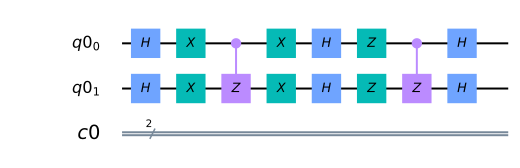

In [8]:
groverCircuit.draw(output="mpl")

### 2.1.1 Experiment with Simulators <a id='2qubits-simulation'></a>

Let's run the circuit in simulation. First, we can verify that we have the correct statevector:

In [9]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(groverCircuit, backend_sim)
statevec = job_sim.result().get_statevector()
print(statevec)

[ 1.00000000e+00-2.44929360e-16j -1.57009246e-16+4.79367020e-32j
 -2.22044605e-16+3.69778549e-32j -1.57009246e-16+2.17894100e-32j]


Now let us measure the state and create the corresponding histogram experiments:

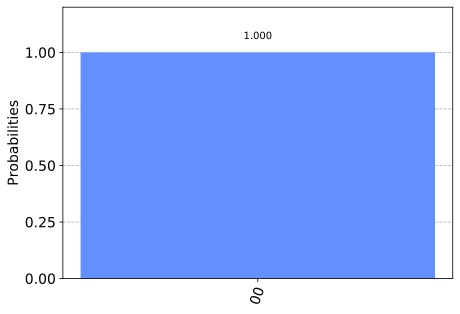

In [10]:
groverCircuit.measure(qr,cr)

backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We confirm that in 100% of the cases the element $|00\rangle$ is found.

### 2.1.2 Experiment with Real Devices <a id='2qubits-device'></a>

We can run the circuit on the real device as below.

In [11]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_london


In [12]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
job = execute(groverCircuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


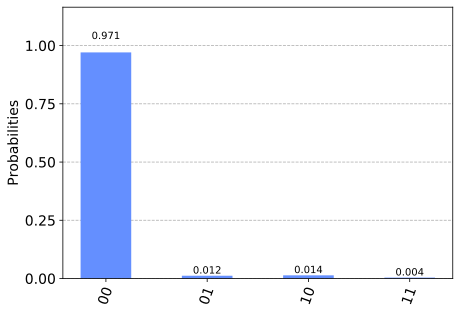

In [13]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

We confirm that in the majority of the cases the element $|00\rangle$ is found. The other results are due to errors in the quantum computation. 

## 3. Example: 3 Qubits <a id='3qubits'></a>

We now go through the example of Grover's algorithm for 3 qubits with two marked states $\lvert101\rangle$ and $\lvert110\rangle$, following the implementation found in Reference [2]. The quantum circuit to solve the problem using a phase oracle is:

![image11](images/grover_circuit_3qubits.png)

<ol>
<li> 
  Apply Hadamard gates to $3$ qubits initialised to $\lvert000\rangle$ to create a uniform superposition:
  $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:
  $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Perform the reflection around the average amplitute:
    
  <ol>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
        \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
    
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right) $$
   </li>

   <li> Apply a doubly controlled Z gate between the 1, 2 (controls) and 3 (target) qubits
      $$\lvert \psi_{3c} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
        -\lvert101\rangle -\lvert110\rangle \right) $$
   </li>
  </ol>
</li>

<li>
  Measure the $3$ qubits to retrieve states $\lvert101\rangle$ and $\lvert110\rangle$
</li>
</ol>

Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration (steps 2 & 3).

### 3.1 Qiskit Implementation <a id='3qubit-implementation'></a>

We now implement Grover's algorithm for the above [example](example) for $3$-qubits and searching for two marked states $\lvert101\rangle$ and $\lvert110\rangle$.

We create a phase oracle that will mark states $\lvert101\rangle$ and $\lvert110\rangle$ as the results (step 1).

In [14]:
def phase_oracle(circuit, register):
    circuit.cz(qr[0],qr[2])
    circuit.cz(qr[1],qr[2])

Next we set up the circuit for inversion about the average (step 2), where we will first need to define a function that creates a multiple-controlled Z gate.

In [15]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [16]:
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
    
    circuit.x(register)
    circuit.h(register)

Now we put the pieces together, with the creation of a uniform superposition at the start of the circuit and a measurement at the end. Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration. 

In [17]:
barriers = True

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()

phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()

inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()

groverCircuit.measure(qr,cr)

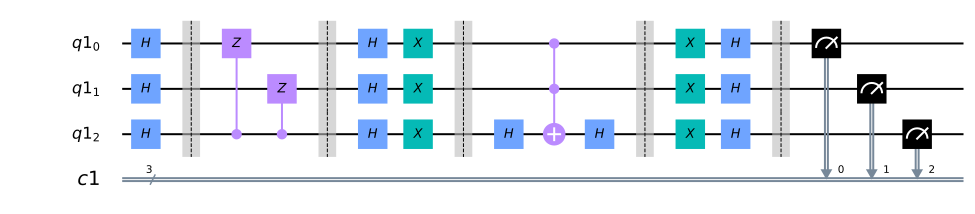

In [18]:
groverCircuit.draw(output="mpl")

### 3.1.1 Experiment with Simulators  <a id='3qubits-simulation'></a>

We can run the above circuit on the simulator. 

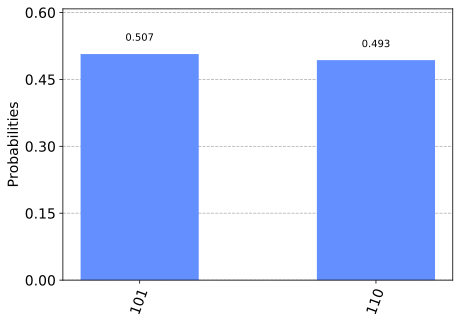

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

As we can see, the algorithm discovers our marked states $\lvert101\rangle$ and $\lvert110\rangle$.

### 3.1.2 Experiment with Real Devices  <a id='3qubits-device'></a>

We can run the circuit on the real device as below.

In [20]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_london


In [21]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


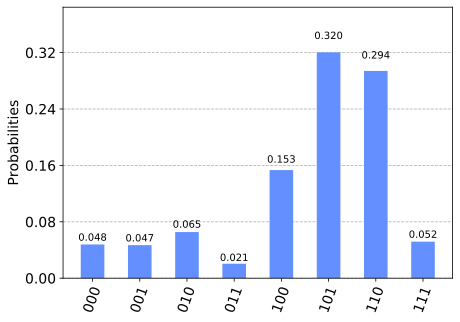

In [22]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

As we can see, the algorithm discovers our marked states $\lvert101\rangle$ and $\lvert110\rangle$. The other results are due to errors in the quantum computation. 

## 4. Problems <a id='problems'></a>

1. The above [example](#example) and [implementation](#implementation) of Grover is to find the two marked $3$-qubit states $\lvert101\rangle$ and $\lvert110\rangle$. Modify the implementation to find one marked $2$-qubit state $\lvert01\rangle$. Are the results what you expect? Explain.

2. The above [example](#example) and [implementation](#implementation) of Grover is to find the two marked $3$-qubit states $\lvert101\rangle$ and $\lvert110\rangle$. Modify the implementation to find one marked $4$-qubit state $\lvert0101\rangle$. Are the results what you expect? Explain.

## 5. References <a id='references'></a>

1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)
3. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.

In [23]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.6',
 'qiskit-aqua': '0.6.4',
 'qiskit': '0.15.0'}